In [1]:
import tensorflow as tf
import mitdeeplearning as mdl

import numpy as np
import pandas as pd
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm

In [2]:
songs = mdl.lab1.load_training_data()

Found 816 songs in text


In [3]:
example_song = songs[0]

print("Example Song")

print(example_song)


Example Song
X:2
T:An Buachaill Dreoite
Z: id:dc-hornpipe-2
M:C|
L:1/8
K:G Major
GF|DGGB d2GB|d2GF Gc (3AGF|DGGB d2GB|dBcA F2GF|!
DGGB d2GF|DGGF G2Ge|fgaf gbag|fdcA G2:|!
GA|B2BG c2cA|d2GF G2GA|B2BG c2cA|d2DE F2GA|!
B2BG c2cA|d^cde f2 (3def|g2gf gbag|fdcA G2:|!


In [4]:
mdl.lab1.play_song(example_song)

In [5]:
#Join the list of song strings into a single string containing all songs
songs_joined ="/n/n".join(songs)

#Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are ",len(vocab)," unique characters in the dataset")

There are  83  unique characters in the dataset


In [6]:
#Create a numerical representation of the text based dataset

#Create a mapping from character to unique index
char2idx={u:i for i,u in enumerate(vocab)}

#Create a mapping from index to characters
idx2char=np.array(vocab)

In [7]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [8]:
#Vectorize the songs to string
def vectorize_string(string):
    vectorized_output = np.array([char2idx[char] for char in string])
    return vectorized_output
vectorized_songs = vectorize_string(songs_joined)
print(vectorized_songs)
    

[49 22 14 ... 22 82  2]


In [9]:
#Batch Definition to Create Training Examples

def get_batch(vectorized_songs,seq_length,batch_size):
    n=vectorized_songs.shape[0]-1
    #Randomly choose the starting indices for the examples in the training batch
    idx=np.random.choice(n-seq_length,batch_size)
    input_batch=[vectorized_songs[i: i+seq_length] for i in idx]
    output_batch=[vectorized_songs[i+1: i+seq_length+1] for i in idx]
    x_batch=np.reshape(input_batch,[batch_size,seq_length])
    y_batch=np.reshape(output_batch,[batch_size,seq_length])
    return x_batch,y_batch
test_args = (vectorized_songs,10,2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
    print("======\n[FAIL] could not pass tests")
else: 
    print("======\n[PASS] passed all tests!")




[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [10]:
x_batch,y_batch = get_batch(vectorized_songs,seq_length=5,batch_size=1)
for i,(input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch),np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 26 ('A')
  expected output: 31 ('F')
Step   1
  input: 31 ('F')
  expected output: 31 ('F')
Step   2
  input: 31 ('F')
  expected output: 14 ('2')
Step   3
  input: 14 ('2')
  expected output: 1 (' ')
Step   4
  input: 1 (' ')
  expected output: 29 ('D')


In [11]:
##DEFINING THE RNN MODEL##
def LSTM(rnn_units):
    return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True
    )

In [12]:
def build_model(vocab_size,embedding_dim,rnn_units,batch_size):
    model=tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size,embedding_dim,batch_input_shape=[batch_size,None]),
        LSTM(rnn_units),
        tf.keras.layers.Dense(vocab_size)
    ])
    
    return model

model = build_model(len(vocab),embedding_dim=256,rnn_units=1024,batch_size=32)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           21248     
_________________________________________________________________
lstm (LSTM)                  (32, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (32, None, 83)            85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Getting training examples and targets
x,y=get_batch(vectorized_songs,seq_length=100,batch_size=32)

#Making prediction
pred=model(x)

In [15]:
#A function to compute loss
def compute_loss(labels,logits):
    loss=tf.keras.losses.sparse_categorical_crossentropy(labels,logits,from_logits=True)
    return loss
example_batch_loss=compute_loss(y,pred)

In [16]:
#Hyper Parameter Setting and Optimization
#optimization Parameters
num_training_iterations=2000
batch_size=4
seq_length=100
learning_rate=5e-3

#Model Parameters
vocab_size=len(vocab)
embedding_dim=256
rnn_units=1024

#Checkpoint Location
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [17]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
# Instantiating an optimizer with its learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
    # Feeding the current input into the model and generating predictions
        y_hat = model(x)
        loss = compute_loss(y, y_hat)
  # Computing the gradients, we want the gradient of the loss with respect to all
  # of the model parameters so will use 'model.trainable_variables' to get a list 
  # of all model parameters
    grads = tape.gradient(loss, model.trainable_variables)
  # Appplying the gradients to the optimizer so it can update the model accordigly
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss


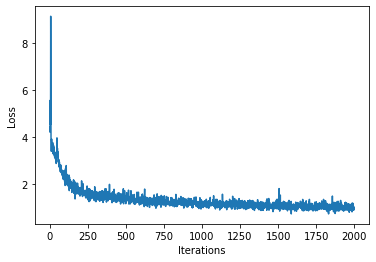

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [1:20:47<00:00,  2.42s/it]


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_2 (Dense)              (1, None, 83)             85075     
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


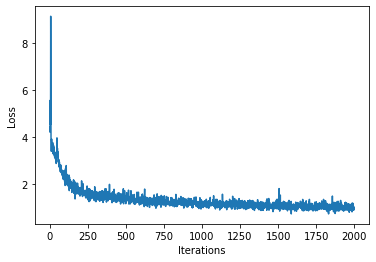

In [18]:
#Beginning of Training

history=[]
plotter=mdl.util.PeriodicPlotter(sec=2,xlabel='Iterations',ylabel='Loss')
if hasattr(tqdm,'_instances'): tqdm._instances.clear()
    
for iter in tqdm(range(num_training_iterations)):
    x_batch, y_batch = get_batch(vectorized_songs,seq_length,batch_size)
    loss=train_step(x_batch,y_batch)
    
    #Update the progress bar
    history.append(loss.numpy().mean())
    plotter.plot(history)
    
    #Update the model with changed weights
    if iter%100==0:
        model.save_weights(checkpoint_prefix)
        
#Save the trained model and the weights
model.save_weights(checkpoint_prefix)

#Generating Music Using the RNN Model
#Rebuild the model using batch_size=1
model=build_model(vocab_size,embedding_dim,rnn_units,batch_size=1)

#Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1,None]))

model.summary()

In [24]:
## Prediction of a generated song
def generate_text(model,start_string,generation_length=1000):
    #Converting start string to numbers
    input_eval = [char2idx[s] for s in start_string]
    #Adding a batch dimension
    input_eval = tf.expand_dims(input_eval,0)
    text_generated=[]
    model.reset_states()
    tqdm._instances.clear()
    
    for i in tqdm(range(generation_length)):
        predictions = model(input_eval)
        #Remove Batch dimension
        predictions = tf.squeeze(predictions,0)
        
        #Use a multinomial distribution to sample
        predicted_id = tf.random.categorical(predictions,num_samples=1)[-1,0].numpy()
        #Passing the prediction along with the previous hidden state as the inputs to the model
        input_eval = tf.expand_dims([predicted_id],0)
        #Adding the predicted character to the generated text
        text_generated.append(idx2char[predicted_id])
    return (start_string + ''.join(text_generated))
generated_text=generate_text(model,start_string="X",generation_length=1000)
generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
    waveform = mdl.lab1.play_song(song)
    if waveform:
        print("Generated song", i)
        ipythondisplay.display(waveform)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.80it/s]

Found 0 songs in text


Found 0 songs in text
